# Embedding analysis

In this notebook we visualize the embeddings learned by the encoder. Run this notebook after training a model via the `encoder.train` module.

We start by importing needed packages.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import argparse
import time

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import DataLoader
import torch_geometric.utils as pyg_utils

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size': 16})
import seaborn as sns

import random
from sklearn.manifold import TSNE
from collections import defaultdict
from itertools import permutations
from queue import PriorityQueue
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import torch.multiprocessing as mp
from sklearn.decomposition import PCA

from common import data
from common import models
from common import utils
from subgraph_matching.config import parse_encoder

Now we load the model and a dataset to analyze embeddings on, here ENZYMES.

In [2]:
parser = argparse.ArgumentParser()

utils.parse_optimizer(parser)
parse_encoder(parser)
args = parser.parse_args("")
args.model_path = os.path.join("..", args.model_path)

print("Using dataset {}".format(args.dataset))
model = models.OrderEmbedder(1, args.hidden_dim, args)
model.to(utils.get_device())
model.eval()
model.load_state_dict(torch.load(args.model_path,
    map_location=utils.get_device()))

train, test, task = data.load_dataset("enzymes")
motifs = []
for i in range(1000):
    graph, neigh = utils.sample_neigh(train, random.randint(3, 29))
    motifs.append(graph.subgraph(neigh))

batch = utils.batch_nx_graphs(motifs)
embs = model.emb_model(batch).detach().cpu().numpy()

max_n_edges = max([len(m.edges) for m in motifs])
max_n_nodes = max([len(m) for m in motifs])

Using dataset syn


600it [00:00, 1018.66it/s]
/opt/anaconda3/envs/testNeuro/lib/python3.11/site-packages/deepsnap/graph.py:522: UserWarning: Node related key is required.
  warnings.warn("Node related key is required.")


Let's visualize the learned order embeddings in 2-D space. We'll use a PCA visualization so that straight lines are preserved. This property implies that all points which are subgraphs of a given point fit inside of a quadrilateral-shaped region. We color the graphs by the number of edges contained in them.

We see that the model learns to organize the space by graph size, which makes sense since bigger graphs cannot be subgraphs of smaller graphs. The model also seems to pick up on some interesting global structure (some points are quite far away from the main sequence).

/var/folders/m0/j_t4z6m53nbbsm9dxrpsktb80000gn/T/ipykernel_56635/1181279601.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis", 12)


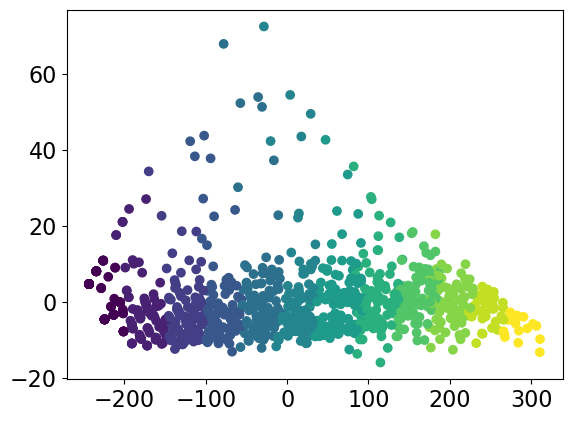

In [3]:
# pca of all embeddings
pca = PCA(n_components=2).fit(embs)
xs, ys = zip(*pca.transform(embs))
cmap = cm.get_cmap("viridis", 12)
colors = [cmap(len(m.edges)/max_n_edges) for m in motifs]
#colors = [cmap(len(m.nodes)/max_n_nodes) for m in motifs]
plt.scatter(xs, ys, color=colors)
plt.show()


Next we investigate a bit the dependence of embeddings on graph size, in terms of both number of nodes and number of edges. We see that the minimum embedding norm for each graph size scales roughly with size, which makes sense given the margin-based objective. Additionally, there is some variation within each graph size, suggesting the model picks up on more than simply size-based cues. There is more variation when measuring graph size by number of edges, which makes sense given the node-induced subgraph setting.

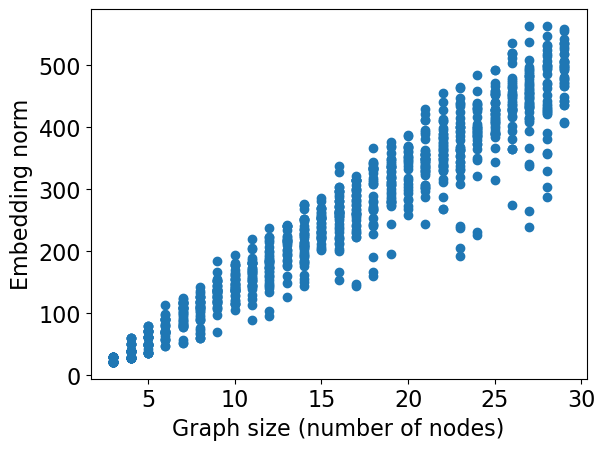

In [4]:
# plot norm vs number of nodes
xs, ys = [len(m) for m in motifs], [np.linalg.norm(emb) for emb in embs]
plt.scatter(xs, ys)
plt.xlabel("Graph size (number of nodes)")
plt.ylabel("Embedding norm")
plt.show()

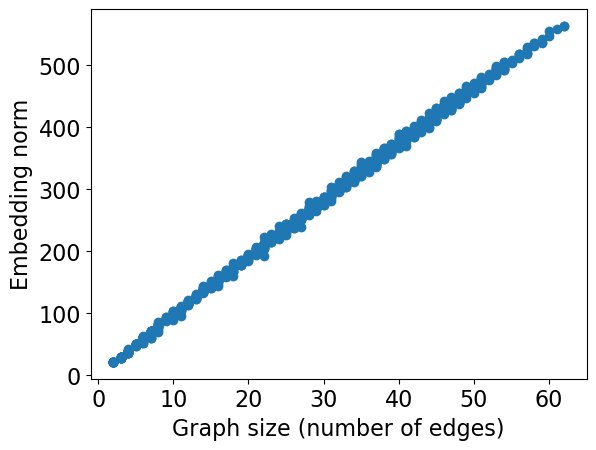

In [5]:
# plot norm vs number of edges
xs, ys = [len(m.edges) for m in motifs], [np.linalg.norm(emb) for emb in embs]
plt.scatter(xs, ys)
plt.xlabel("Graph size (number of edges)")
plt.ylabel("Embedding norm")
plt.show()


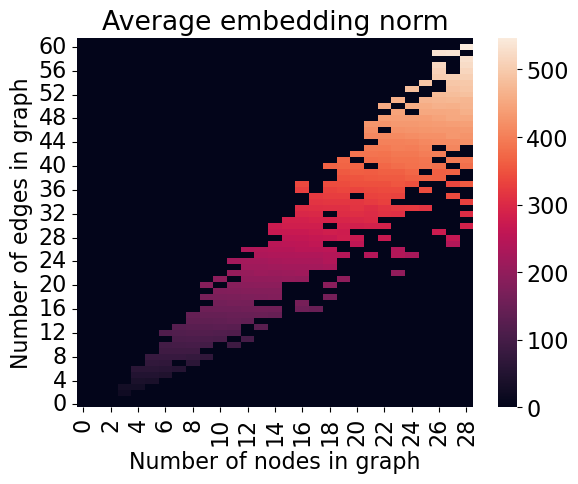

In [6]:
# heatmap of node size vs edge size vs embedding norm
a = defaultdict(lambda: defaultdict(list))
for m, emb in zip(motifs, embs):
    a[len(m)][len(m.edges)].append(np.linalg.norm(emb))
a_mat = np.zeros((max_n_edges, max_n_nodes))
for i in range(max_n_nodes):
    for j in range(max_n_edges):
        a_mat[j][i] = np.mean(a[i][j] if a[i][j] else 0)
ax = sns.heatmap(a_mat, linewidth=0)
ax.invert_yaxis()
plt.xlabel("Number of nodes in graph")
plt.ylabel("Number of edges in graph")
plt.title("Average embedding norm")
plt.show()
